In [1]:
from __future__ import division, print_function

In [2]:
from PIL import Image

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

**Utils**

In [3]:
def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/fps), loop=loop)

In [4]:
style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"

In [5]:
def style_plot(x, y, x_data, y_data, yh, xp=None):
    style = "https://raw.githubusercontent.com/nicoguaro/matplotlib_styles/master/styles/clean.mplstyle"
    with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")
        if y_data is not None:            
            plt.scatter(x_data, y_data, label='Training data')
        if yh is not None:
            plt.plot(x, yh, label="Neural network prediction")
        if xp is not None:
            plt.scatter(xp, -0*torch.ones_like(xp), label='Physics loss training locations')
        plt.annotate("Training step: %i"%(i+1), 
             xy=(0, 1), 
             xycoords='axes fraction', 
             fontsize="small", 
             color="k",
             ha='left', 
             va='top')
        plt.legend(loc='best')

### **RNN**

In [6]:
def f_rhs(x):
   return -4*torch.sin(2 * x)

def exact_u(x):
    return torch.sin(2 * x)

def exact_u_singular(x):
  return x**0.7 * (x - torch.pi)

def f_singular_rhs(x):
  return -0.7 * 0.3 * (x**-1.3) * (x - torch.pi) + (0.7*x**-0.3) * (1) + (0.7 * x**-0.3)  

class RNNPDE(nn.Module):
    def __init__(self):
        super(RNNPDE, self).__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=10, batch_first=True, nonlinearity='tanh')
        self.fc = nn.Sequential(
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 10),
            nn.Tanh(),
            nn.Linear(10, 1)
        )

    def forward(self, x):
        x = x.unsqueeze(2)  
        out, _ = self.rnn(x) 
        out = out[:, -1, :]  
        out = self.fc(out) 
        return out.squeeze(1)

**Training Data**

torch.Size([1000, 1]) torch.Size([1000, 1])
torch.Size([15, 1]) torch.Size([15, 1])


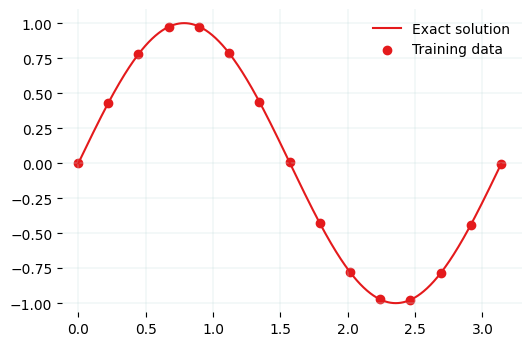

In [7]:
n_pts = 1000

x = np.array([np.pi/n_pts * i for i in range(n_pts)])
x = torch.tensor(x, dtype=torch.float32).view(-1, 1)
y = exact_u(x).view(-1, 1)
print(x.shape, y.shape)

num_samples = 15
indices = np.linspace(0, len(x)-1, num_samples, dtype=int)
x_data = x[indices]
y_data = y[indices]
print(x_data.shape, y_data.shape)

with plt.style.context(style):        
        fig = plt.figure()
        ax = plt.subplot(111)
        plt.plot(x, y, label="Exact solution")        
        plt.scatter(x_data, y_data, label='Training data')        
        plt.legend()
        plt.show()

In [15]:
torch.manual_seed(123)
model = RNNPDE()
model

RNNPDE(
  (rnn): RNN(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)

**Params**

In [16]:
total_params = sum(p.numel() for p in model.parameters())
print(f'Total number of parameters: {total_params}')

Total number of parameters: 361


### **RNN**

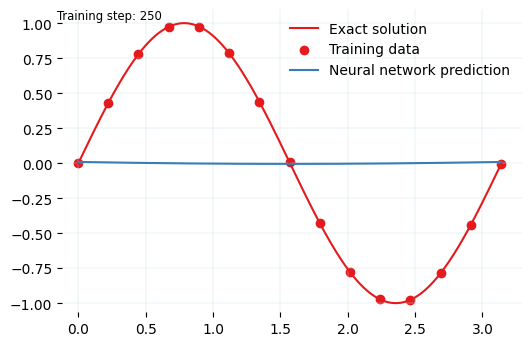

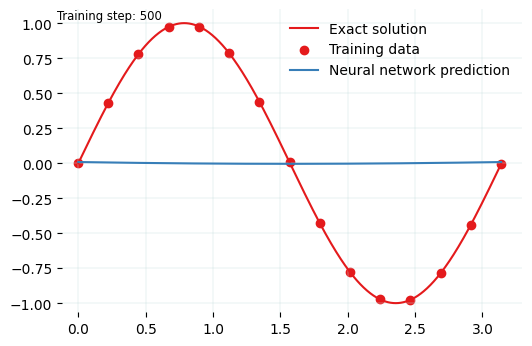

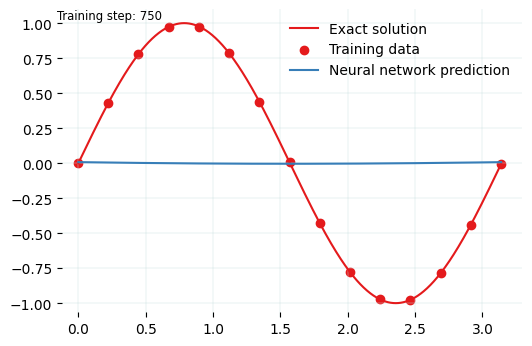

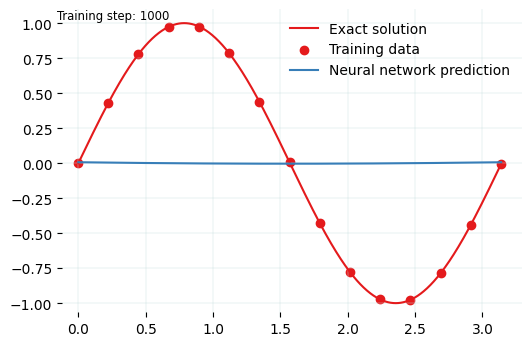

In [17]:
model = RNNPDE()
n_iterations = 1000
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
for i in range(n_iterations):
    optimizer.zero_grad()
    yh = model(x_data)
    loss = torch.mean((yh-y_data)**2)
    loss.backward()
    optimizer.step()

    if (i+1) % 10 == 0:
        yh = model(x).detach()
        style_plot(x, y, x_data, y_data, yh)
        file = "plots/nn_%.8i.png"%(i+1)    
        plt.savefig(file, bbox_inches=None, pad_inches=0.5, dpi=100, facecolor="white")
        files.append(file)

    if (i+1) % 250 == 0: plt.show()
    else: plt.close("all")
save_gif_PIL("rnn_sen_data_gif.gif", files, fps=20, loop=0)

### **PIRNN**

Loss at iteration 50: 7.959293
Loss at iteration 100: 8.171202
Loss at iteration 150: 6.362605
Loss at iteration 200: 2.584462
Loss at iteration 250: 0.315625


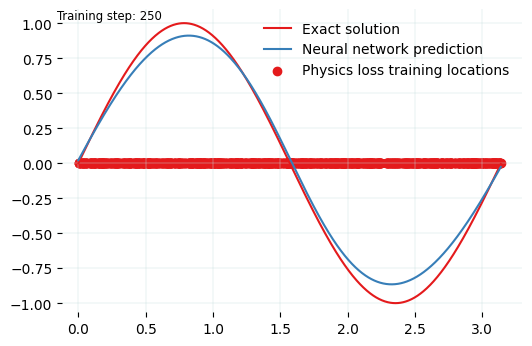

Loss at iteration 300: 0.059280
Loss at iteration 350: 0.018604
Loss at iteration 400: 0.006519
Loss at iteration 450: 0.003163
Loss at iteration 500: 0.001695


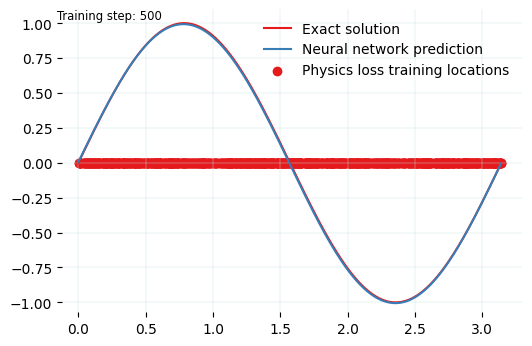

In [14]:
x_physics = torch.FloatTensor(n_pts, 1).uniform_(0, np.pi).requires_grad_(True)
iterations = 500

torch.manual_seed(123)
model = RNNPDE()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
files = []
losses = []
output_errors = []

for i in range(iterations):
    x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)
    optimizer.zero_grad()

    # Physic loss
    yhp = model(x_physics)
    du = torch.autograd.grad(yhp, x_physics, torch.ones_like(yhp), create_graph=True)[0]
    ddu = torch.autograd.grad(du, x_physics, torch.ones_like(du), create_graph=True)[0]
    error_PDE = torch.mean((ddu - f_rhs(x_physics))**2)
    bc = model(torch.tensor([np.pi]).unsqueeze(0))**2 + model(torch.tensor([0.]).unsqueeze(0))**2
    
    # Backpropagation
    loss = error_PDE + bc
    loss.backward()
    optimizer.step()
    losses.append(loss.item())

    # Calculo del error MSE 
    exact_function = exact_u(x_physics)
    predicted_function = model(x_physics).detach()
    error_between_arrays = exact_function - predicted_function
    output_error = torch.mean((error_between_arrays)**2)
    output_error /= torch.mean(exact_function**2)
    output_errors.append(output_error.item())

    if (i+1) % 50 == 0:
        print(f"Loss at iteration {i+1}: {loss.item():.6f}")

    if (i+1) % 10 == 0:

        yh = model(x).detach()
        xp = x_physics.detach()

        #plot_result(x,y,x_data,y_data,yh,xp)
        style_plot(x, y, x_data=None, y_data=None, yh=yh, xp=xp)

        file = "plots/pinn_%.8i.png"%(i+1)
        plt.savefig(file, bbox_inches=None, pad_inches=0.1, dpi=100, facecolor="white")
        files.append(file)

        if (i+1) % 250 == 0: plt.show()
        else: plt.close("all")
save_gif_PIL("rnn_sen_physics_gif.gif", files, fps=20, loop=0)

**MSE Error**

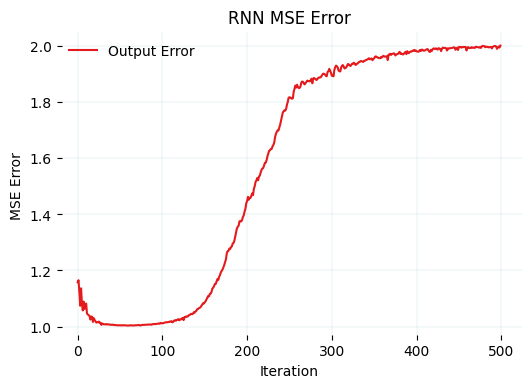

In [15]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("RNN MSE Error")
    plt.plot(output_errors, label="Output Error")
    plt.xlabel("Iteration")
    plt.ylabel('MSE Error')             
    plt.legend()
    
    # Guardar la gráfica
    plt.savefig('rnn_sen_physics_error_mse.png', dpi=300, bbox_inches='tight')
    
    plt.show()

**Loss Function**

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


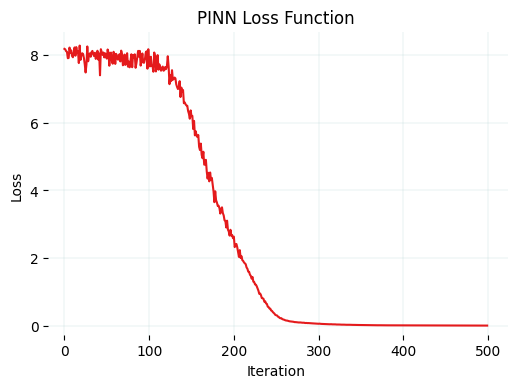

In [16]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.plot(losses)
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()
    
    # Guardar la gráfica
    plt.savefig('rnn_sen_physics_loss_function.png', dpi=300, bbox_inches='tight')
    
    plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


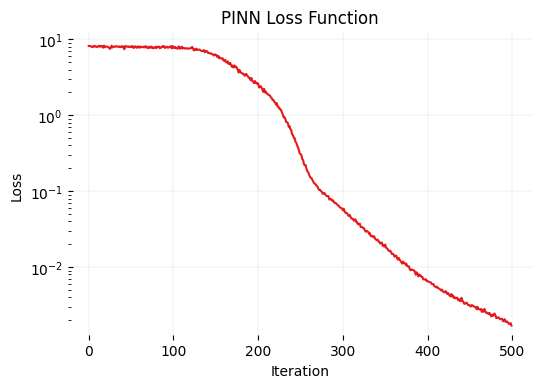

In [17]:
with plt.style.context(style):        
    fig = plt.figure()
    ax = plt.subplot(111)
    plt.title("PINN Loss Function")
    plt.semilogy(losses)  
    plt.xlabel("Iteration")
    plt.ylabel('Loss')             
    plt.legend()

    # Guardar la gráfica
    plt.savefig('rnn_sen_physics_semilogy_loss_function.png', dpi=300, bbox_inches='tight')

    plt.show()

##### **Error**

In [18]:
x_physics = torch.FloatTensor(n_pts,1).uniform_(0, np.pi).requires_grad_(True)

exact_function = exact_u(x_physics)
predicted_function = model(x_physics).detach()
error_between_arrays = exact_function - predicted_function

Mean Squared Error (MSE)

In [19]:
# Error relativo
output_error = torch.mean((error_between_arrays)**2)
output_error /= torch.mean(exact_function**2)
print(f"Output error: {output_error.item():.8f}")

Output error: 2.00055385


Max Error

In [20]:
max_error = torch.max(torch.abs(error_between_arrays))
max_error /= torch.max(torch.abs(exact_function))
print(f"Max error: {max_error.item():.8f}")

Max error: 2.00523925


Min Error

In [21]:
min_error = torch.min(torch.abs(error_between_arrays))
min_error /= torch.min(torch.abs(exact_function))
print(f"Min error: {min_error.item():.8f}")

Min error: 0.00066357


Avg Error

In [22]:
avg_error = torch.mean(torch.abs(error_between_arrays))
avg_error /= torch.mean(torch.abs(exact_function))
print(f"Avg error: {avg_error.item():.8f}")

Avg error: 1.26099980


**Save PIRNN model**

In [21]:
torch.save(model.state_dict(), 'models/poisson1_pirnn.pth')

In [22]:
model = RNNPDE()
model.load_state_dict(torch.load("models/poisson1_pirnn.pth"))

<All keys matched successfully>

In [23]:
model.eval()

RNNPDE(
  (rnn): RNN(1, 10, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=10, out_features=10, bias=True)
    (1): Tanh()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): Tanh()
    (4): Linear(in_features=10, out_features=1, bias=True)
  )
)